In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = "/content/drive/MyDrive/garbage-classification"

from torchvision import datasets
base_dataset = datasets.ImageFolder(root=DATA_DIR, transform=None)

import os
print("Classes found:", os.listdir(DATA_DIR))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classes found: ['plastic', 'metal', 'cardboard', 'paper', 'glass']


In [ ]:
!pip install torch torchvision --quiet

**Import Libraries**

In [ ]:
import os, time, random, copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR

import timm

**Exploratory Data Analysis**

Class distribution: {'cardboard': 413, 'glass': 511, 'metal': 410, 'paper': 594, 'plastic': 492}


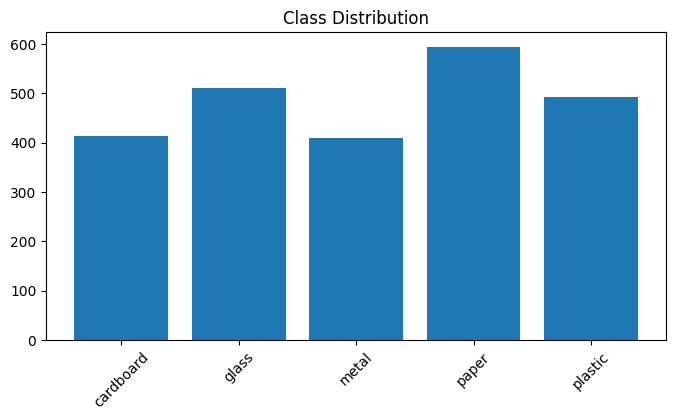

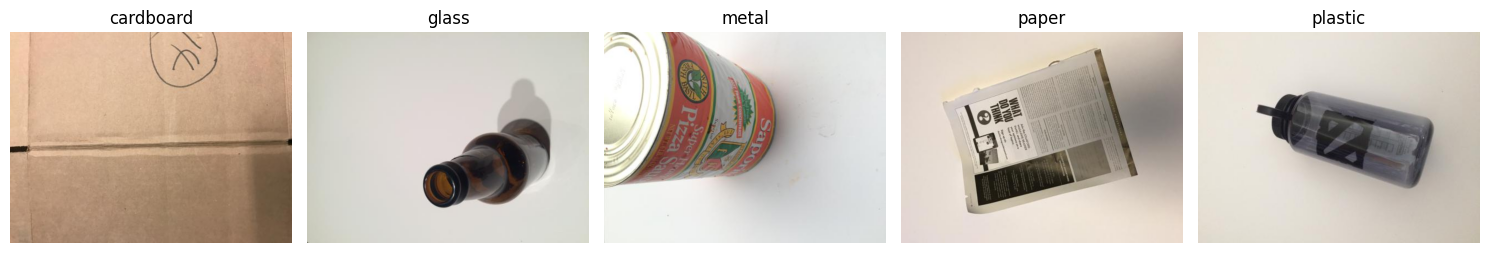

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import datasets

# Updated class names and counts
class_names = base_dataset.classes
num_classes = len(class_names)

# Class counts
counts = Counter(base_dataset.targets)
print("Class distribution:", {class_names[i]: counts[i] for i in range(num_classes)})

# Plot bar chart
plt.figure(figsize=(8,4))
plt.bar(class_names, [counts[i] for i in range(num_classes)])
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()

# Pick 1 sample index for each class
sample_indices = []
seen = set()
for i, label in enumerate(base_dataset.targets):
    if label not in seen:
        sample_indices.append(i)
        seen.add(label)
    if len(seen) == num_classes:
        break

# Plot one image per class
fig, axes = plt.subplots(1, num_classes, figsize=(3*num_classes, 3))
for ax, idx in zip(axes, sample_indices):
    img, label = base_dataset[idx]
    ax.imshow(img)
    ax.set_title(class_names[label])
    ax.axis("off")
plt.tight_layout()
plt.show()


**Helper Functions**

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def build_transforms(img_size=224):
    train_tfms = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225)),
    ])
    val_test_tfms = transforms.Compose([
        transforms.Resize(int(img_size * 1.14)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225)),
    ])
    return train_tfms, val_test_tfms

def stratified_indices(labels, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    num_classes = max(labels) + 1
    per_class = [[] for _ in range(num_classes)]
    for idx, y in enumerate(labels):
        per_class[y].append(idx)
    rng = random.Random(seed)
    train_idx, val_idx, test_idx = [], [], []
    for cls, idxs in enumerate(per_class):
        rng.shuffle(idxs)
        n = len(idxs)
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)
        train_idx.extend(idxs[:n_train])
        val_idx.extend(idxs[n_train:n_train+n_val])
        test_idx.extend(idxs[n_train+n_val:])
    rng.shuffle(train_idx); rng.shuffle(val_idx); rng.shuffle(test_idx)
    return train_idx, val_idx, test_idx


**Load Dataset**

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
LR = 5e-4

train_tfms, val_test_tfms = build_transforms(IMG_SIZE)
base_dataset = datasets.ImageFolder(root=DATA_DIR, transform=None)
class_names = base_dataset.classes
num_classes = len(class_names)
print("Detected Classes:", class_names)

# Split into train / val / test
train_idx, val_idx, test_idx = stratified_indices(base_dataset.targets)

train_ds = copy.copy(base_dataset); train_ds.transform = train_tfms
val_ds   = copy.copy(base_dataset); val_ds.transform = val_test_tfms
test_ds  = copy.copy(base_dataset); test_ds.transform = val_test_tfms

train_set, val_set, test_set = Subset(train_ds, train_idx), Subset(val_ds, val_idx), Subset(test_ds, test_idx)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)



Detected Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic']


**Model Building** - MaxVit Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model("maxvit_tiny_rw_224", pretrained=True, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

scaler = torch.cuda.amp.GradScaler()  # mixed precision


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/tmp/ipython-input-2729252428.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # mixed precision


**Training Loop**

In [ ]:
def train_one_epoch():
    model.train()
    total, correct, running_loss = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total, correct, running_loss = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total


best_acc = 0
for epoch in range(1, EPOCHS+1):
    t_loss, t_acc = train_one_epoch()
    v_loss, v_acc = evaluate(val_loader)
    scheduler.step()
    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train Acc {t_acc*100:.2f}% | Val Acc {v_acc*100:.2f}%")
    if v_acc > best_acc:
        best_acc = v_acc
        torch.save(model.state_dict(), "/content/drive/MyDrive/maxvit_best.pth")
        print("  ↳ Saved new best model")



/tmp/ipython-input-4266812502.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 01/20 | Train Acc 68.56% | Val Acc 87.97%
  ↳ Saved new best model
Epoch 02/20 | Train Acc 86.56% | Val Acc 89.63%
  ↳ Saved new best model
Epoch 03/20 | Train Acc 90.28% | Val Acc 88.38%
Epoch 04/20 | Train Acc 93.23% | Val Acc 73.86%
Epoch 05/20 | Train Acc 94.16% | Val Acc 83.40%
Epoch 06/20 | Train Acc 95.24% | Val Acc 91.29%
  ↳ Saved new best model
Epoch 07/20 | Train Acc 96.48% | Val Acc 92.53%
  ↳ Saved new best model
Epoch 08/20 | Train Acc 97.26% | Val Acc 93.36%
  ↳ Saved new best model
Epoch 09/20 | Train Acc 97.88% | Val Acc 91.70%
Epoch 10/20 | Train Acc 98.14% | Val Acc 92.53%
Epoch 11/20 | Train Acc 98.66% | Val Acc 95.85%
  ↳ Saved new best model
Epoch 12/20 | Train Acc 99.74% | Val Acc 94.19%
Epoch 13/20 | Train Acc 99.90% | Val Acc 96.27%
  ↳ Saved new best model
Epoch 14/20 | Train Acc 100.00% | Val Acc 95.85%
Epoch 15/20 | Train Acc 99.79% | Val Acc 95.02%
Epoch 16/20 | Train Acc 99.84% | Val Acc 95.02%
Epoch 17/20 | Train Acc 99.74% | Val Acc 95.85%
Epoch 18

**Test Evaluation**

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/maxvit_best.pth", map_location=device))
test_loss, test_acc = evaluate(test_loader)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")


Final Test Accuracy: 95.10%


**Testing the Model** (Real Time Prediction)

Testing 1

In [ ]:
from google.colab import files
from PIL import Image
import torchvision.transforms as transforms
import torch
import timm

# Upload image
uploaded = files.upload()

# Get filename
image_path = list(uploaded.keys())[0]
print("Uploaded:", image_path)


Saving Screenshot 2025-08-19 124015.png to Screenshot 2025-08-19 124015.png
Uploaded: Screenshot 2025-08-19 124015.png


In [ ]:
model = timm.create_model("maxvit_tiny_rw_224", pretrained=False, num_classes=len(class_names)).to(device)

# Load best trained weights
model.load_state_dict(torch.load("/content/drive/MyDrive/maxvit_best.pth", map_location=device))
model.eval()

# Same preprocessing as validation
val_tfms = transforms.Compose([
    transforms.Resize(int(224 * 1.14)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])

# Open and preprocess image
img = Image.open(image_path).convert("RGB")
input_tensor = val_tfms(img).unsqueeze(0).to(device)

# Predict
with torch.no_grad():
    outputs = model(input_tensor)
    preds = outputs.argmax(1).item()

print("Predicted class:", class_names[preds])


Predicted class: glass


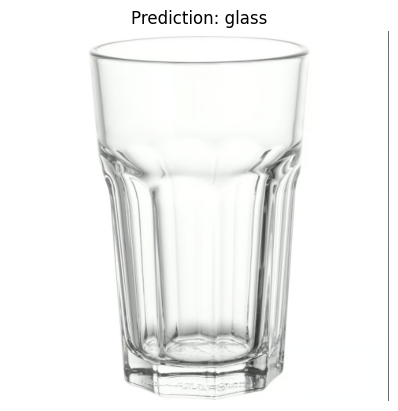

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(f"Prediction: {class_names[preds]}")
plt.axis("off")
plt.show()

Testing 2

In [ ]:
from google.colab import files
from PIL import Image
import torchvision.transforms as transforms
import torch
import timm

# Upload image
uploaded = files.upload()

# Get filename
image_path = list(uploaded.keys())[0]
print("Uploaded:", image_path)


Saving Screenshot 2025-08-19 201017.png to Screenshot 2025-08-19 201017.png
Uploaded: Screenshot 2025-08-19 201017.png


In [ ]:
model = timm.create_model("maxvit_tiny_rw_224", pretrained=False, num_classes=len(class_names)).to(device)

# Load best trained weights
model.load_state_dict(torch.load("/content/drive/MyDrive/maxvit_best.pth", map_location=device))
model.eval()

# Same preprocessing as validation
val_tfms = transforms.Compose([
    transforms.Resize(int(224 * 1.14)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])

# Open and preprocess image
img = Image.open(image_path).convert("RGB")
input_tensor = val_tfms(img).unsqueeze(0).to(device)

# Predict
with torch.no_grad():
    outputs = model(input_tensor)
    preds = outputs.argmax(1).item()

print("Predicted class:", class_names[preds])


Predicted class: metal


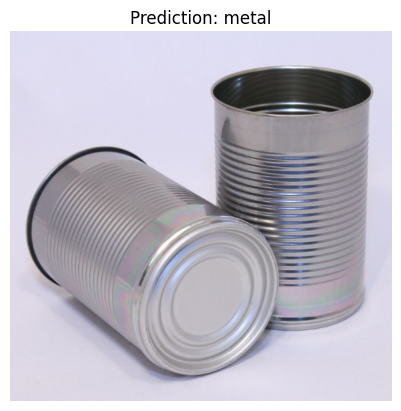

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(f"Prediction: {class_names[preds]}")
plt.axis("off")
plt.show()